<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S15/DenseDepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [1]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-e87a240f-5bad-212d-0c45-32633c80c49a)


## Downgrade the version of tensor flow

In [3]:
%tensorflow_version 1.13

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


## Clone the repo and load libraries

In [4]:
import sys 

!rm -rf DenseDepth
!git clone https://github.com/raguram/DenseDepth.git
sys.path.append("/content/DenseDepth")

%rm -rf /content/eva
!git clone https://github.com/raguram/eva.git

sys.path.append("/content/eva/cnn-lib/src/cnnlib")
sys.path.append("/content/eva/cnn-lib/src/")
print("Added required libraries to system path")

Cloning into 'DenseDepth'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 270 (delta 17), reused 16 (delta 7), pack-reused 235
Receiving objects: 100% (270/270), 11.84 MiB | 6.61 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Cloning into 'eva'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (324/324), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 603 (delta 130), reused 188 (delta 55), pack-reused 279
Receiving objects: 100% (603/603), 30.57 MiB | 9.64 MiB/s, done.
Resolving deltas: 100% (254/254), done.
Added required libraries to system path


## Download weights

In [11]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./nyu.h5

--2020-05-17 12:08:42--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.28.203
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.28.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./nyu.h5’

./nyu.h5            100%[===================>] 164.89M  11.9MB/s    in 27s     

2020-05-17 12:09:11 (6.02 MB/s) - ‘./nyu.h5’ saved [172897376/172897376]



## Download and unzip the data set 

In [11]:
!rm -rf /content/input
!unzip /content/drive/My\ Drive/Colab\ Notebooks/workspace/data/Assignment15/data.zip -d /content/input

Streaming output truncated to the last 5000 lines.
 extracting: /content/input/fg_bg/Image_42_170_178126.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178127.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178128.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178129.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178130.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178131.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178132.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178133.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178134.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178135.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178136.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178137.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178138.JPEG  
 extracting: /content/input/fg_bg/Image_42_170_178139.JPEG  
 extracting: /content/input/fg_bg_mask/Image_42_170_178120.JPEG  
 extracting: /content/input/f

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 extracting: /content/input/fg_bg/Image_85_10_353804.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353805.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353806.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353807.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353808.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353809.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353810.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353811.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353812.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353813.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353814.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353815.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353816.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353817.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353818.JPEG  
 extracting: /content/input/fg_bg/Image_85_10_353

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 extracting: /content/input/fg_bg/Image_109_83_455101.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455102.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455103.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455104.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455105.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455106.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455107.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455108.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455109.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455110.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455111.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455112.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455113.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455114.JPEG  
 extracting: /content/input/fg_bg/Image_109_83_455115.JPEG  
 extracting: /content/input/fg_bg/

In [0]:
!cp /content/drive/My\ Drive/Colab\ Notebooks/workspace/data/Assignment15/data.zip /content/output

In [23]:
%ls -altr /content/output-dir


total 7187344
-rw------- 1 root root 7359827597 May 17 13:03 data.zip
drwxr-xr-x 1 root root       4096 May 17 13:11 ../
drwxr-xr-x 2 root root       4096 May 17 13:11 ./


In [0]:
!rm -rf /content/input/fg_bg_mask

## Import 

In [5]:
import sys
sys.path.append("/content/DenseDepth")

import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
from utils import predict, load_images, display_images
from matplotlib import pyplot as plt
from PIL import Image
import DepthPredictor

Using TensorFlow backend.


## Setup Arguments




In [0]:
model_path = "/content/nyu.h5"

## Load model 

In [7]:
# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(model_path, custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format(model_path))

Loading model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.




Model loaded (/content/nyu.h5).


## Sample 

Number of url files:457600


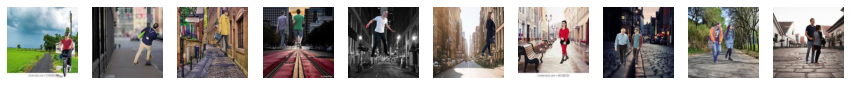

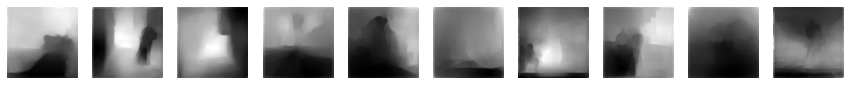

In [15]:
from utils import load_images
from os import listdir
from os.path import join
from DepthPredictor import DepthPredictor
import ImageUtils

files = [join("/content/input/fg_bg", f) for f in listdir("/content/input/fg_bg")]
print(f"Number of url files:{len(files)}")
images = load_images(files[20:30])

predictor = DepthPredictor(model)
depth_images = predictor.predict(images)
ImageUtils.show_images(images)
ImageUtils.show_images(depth_images, cols=10)

## Predict Depth



In [24]:
from ImageDao import ZipFileImagePersister
from zipfile import ZipFile
from utils import load_images

zip = ZipFile("/content/output-dir/data.zip", "a")
output_writer = ZipFileImagePersister(zip, "fg_bg_depth")
predictor = DepthPredictor(model, batch_size=1024)

predictor.predict_all_images_from_folder("/content/input/fg_bg", output_writer)
zip.close()

Total number of files: 457600
Processed batch 0. Time Taken: 0:01:01.213799
Processed batch 1. Time Taken: 0:01:00.875558
Processed batch 2. Time Taken: 0:01:03.272344
Processed batch 3. Time Taken: 0:01:03.082281
Processed batch 4. Time Taken: 0:01:03.097982
Processed batch 5. Time Taken: 0:01:02.764753
Processed batch 6. Time Taken: 0:01:02.112684
Processed batch 7. Time Taken: 0:01:02.125061
Processed batch 8. Time Taken: 0:01:02.419439
Processed batch 9. Time Taken: 0:01:02.230876
Processed batch 10. Time Taken: 0:01:02.015879
Processed batch 11. Time Taken: 0:01:01.951443
Processed batch 12. Time Taken: 0:01:02.085283
Processed batch 13. Time Taken: 0:01:01.681479
Processed batch 14. Time Taken: 0:01:01.743639
Processed batch 15. Time Taken: 0:01:01.642799
Processed batch 16. Time Taken: 0:01:01.680061
Processed batch 17. Time Taken: 0:01:01.529787
Processed batch 18. Time Taken: 0:01:01.748659
Processed batch 19. Time Taken: 0:01:01.714377
Processed batch 20. Time Taken: 0:01:01.

## Copy the zip file to drive

In [0]:
%cp -r /content/output-dir/data.zip /content/drive/My\ Drive/Colab\ Notebooks/workspace/data/Assignment15/

In [27]:
!mkdir fg_bg_depth
!unzip /content/output-dir/data.zip 'fg_bg_depth/*' -d /content/fg_bg_depth

Streaming output truncated to the last 5000 lines.
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_46_80_192970.JPEG  
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_20_28_83777.JPEG  
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_75_206_316121.JPEG  
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_76_103_318238.JPEG  
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_34_117_143786.JPEG  
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_14_46_59161.JPEG  
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_65_60_271605.JPEG  
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_29_95_122548.JPEG  
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_91_30_379172.JPEG  
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_71_28_295929.JPEG  
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_11_29_46346.JPEG  
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_81_11_337187.JPEG  
 extracting: /content/fg_bg_depth/fg_bg_depth/Image_6_95_26864.JPEG  
 extracting: /c

Number of url files:457600


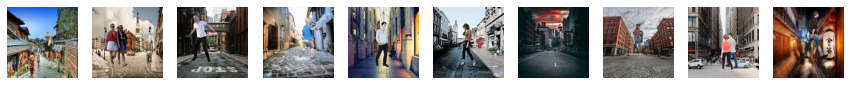

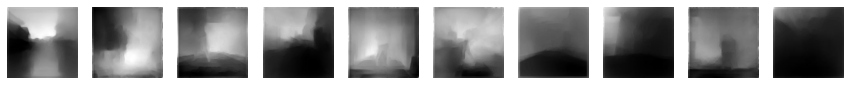

In [31]:
depth = [join("/content/fg_bg_depth/fg_bg_depth", f) for f in listdir("/content/fg_bg_depth/fg_bg_depth")]
fg_bg = [join("/content/input/fg_bg", f) for f in listdir("/content/input/fg_bg")]

print(f"Number of url files:{len(files)}")
fg_bg_images = load_images(fg_bg[:10])
depth_images = load_images(depth[:10])

ImageUtils.show_images(fg_bg_images, cols=10)
ImageUtils.show_images(depth_images, cols=10)